In [14]:

import json
import pandas as pd 
import numpy as np
import pycocotools
import matplotlib.pyplot as plt
from pprint import pprint
from glob import glob
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import imageio
import os
import sys
sys.path.append('../scripts')
import utils
import lightning as pl

In [9]:
MAIN_PATH = '../../../dataset'
ANNOT_PATH = f'{MAIN_PATH}/rough_annots.json'
IMAGES_PATHS = sorted(glob(MAIN_PATH+'/Seek Thermal/jpegs/*'))
MASKS_PATHS = sorted(glob(MAIN_PATH+'/Seek Thermal/masks/*.png'))
with open(ANNOT_PATH, 'r') as f:
    annot = json.load(f)

In [ ]:
# count = 0
for k, v in annot.items():
    # pprint(v['regions'][])
    for region in v['regions']:
        print(region)
        break
    # image_path = MAIN_PATH+f'/Seek Thermal/jpegs/{k[:-6]}'
    # image = Image.open(image_path)
    # width, height = image.size
    # mask = Image.new('L', (width, height), 0)
    
    
    # plt.imshow(image)
    break

In [ ]:
# os.mkdir(MAIN_PATH+f'/Seek Thermal/masks/')

In [ ]:
for k, v in annot.items():
    if v['regions'].__len__() > 0:
        image_path = MAIN_PATH+f'/Seek Thermal/jpegs/{k[:-6]}'
        image = Image.open(image_path)
        width, height = image.size
        s = max(width, height)
        mask = Image.new('L', (s, s), 0)
        # print(k, '🔁')
        
        for region in (v['regions']):
            if region:
                
                polygon = list(zip(region['shape_attributes']['all_points_x'], region['shape_attributes']['all_points_y']))
                if region['region_attributes']['class'] == 'glass':
                    ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
                elif region['region_attributes']['class'] == 'liquid':
                    ImageDraw.Draw(mask).polygon(polygon, outline=2, fill=2)

        mask_array = np.array(mask)
        print(k, np.unique(mask_array))
        imageio.imwrite(MAIN_PATH+f'/Seek Thermal/masks/'+k.split('.jpg')[0]+'.png', mask_array)
        
        # plt.imshow(image)
        # plt.imshow(mask_array, alpha=0.4)
        # plt.axis('off')
# annot[keys[0]]['regions'][1]
# annot[list(annot.keys)[0]]


In [ ]:
# img =  imageio.imread(IMAGES_PATHS[2])
from random import randint
idx = randint(0,MASKS_PATHS.__len__() - 1)
print(idx)
mask =  imageio.imread(MASKS_PATHS[idx])
img_path = '/'.join(MASKS_PATHS[idx].split('/')[:-1]) + '/jpegs/' + MASKS_PATHS[idx].split("\\")[-1][:-4] + '.jpg'
img = np.array(Image.open(img_path))
print(img.shape, mask.shape)
if img.shape[:-1] != mask.shape:
    img = utils.rotate_to_vertical(img_path)
plt.imshow(img)
plt.imshow(mask, alpha=0.7)
plt.show()

C:\Users\Ayan.Gupta\AppData\Local\Temp\ipykernel_22804\1374109903.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)


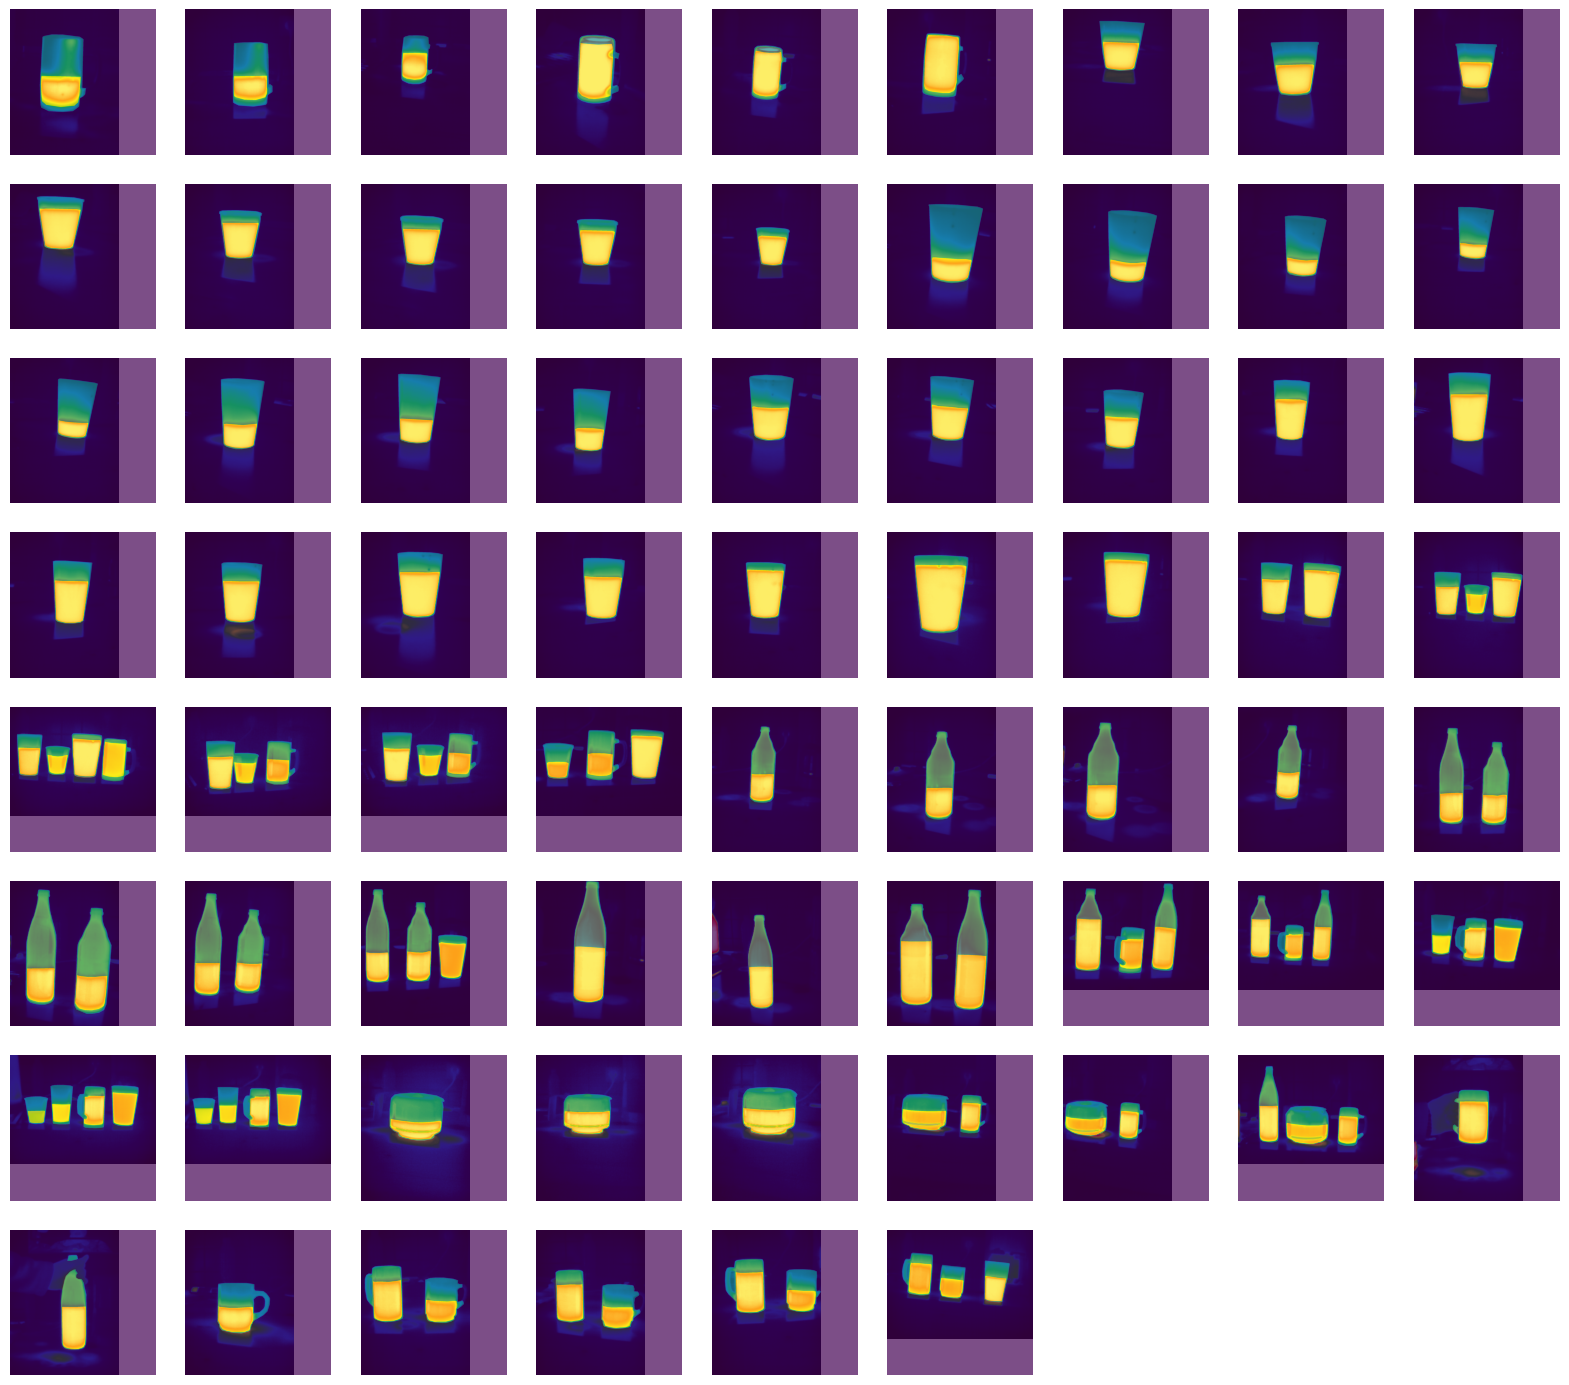

In [12]:
n = MASKS_PATHS.__len__()  # total number of images

grid_shape = (int(np.sqrt(n))+1, int(np.sqrt(n))+1)

fig, axs = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1], figsize=(20, 20))

axs = axs.flatten()

for i, mask_path in enumerate(MASKS_PATHS):
    mask = imageio.imread(mask_path)
    img_path = '/'.join(mask_path.split('/')[:-1]) + '/jpegs/' + mask_path.split("\\")[-1][:-4] + '.jpg'
    img = np.array(Image.open(img_path))

    if img.shape[:-1] != mask.shape:
        img = utils.rotate_to_vertical(img_path)

    ax = axs[i]

    ax.imshow(img)

    ax.imshow(mask, alpha=0.7)
    ax.axis('off')

for ax in axs[n:]:
    ax.remove()

plt.show()

In [1]:
# import os



8

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2

class RemoteSensingDataset(Dataset):
    def __init__(self, rasters, targets, width=512, transform=None):
        self.rasters = rasters
        self.targets = targets
        self.width = width
        self.transform = transform

    def __len__(self):
        return len(self.rasters)
    
    def read_image(self, path):
        return imageio.imread(path)

    def __getitem__(self, idx):
        raster = self.read_image(self.rasters[idx])
        img_w, img_h = raster.shape[:2]
        target = self.read_image(self.targets[idx])[:img_w,:img_h,:]
        
        raster = cv2.resize(raster,(self.width, self.width), interpolation=cv2.INTER_CUBIC)
        target = cv2.resize(target,(self.width, self.width), interpolation=cv2.INTER_CUBIC)
        
        temp_target = np.stack([target, target], axis=-1)
        temp_target[...,0] = temp_target[...,0] > 0
        temp_target[...,1] = temp_target[...,1] == 2
        temp_target = temp_target.astype(np.uint8)
                
        if self.transform:
            transformed = self.transform(image=raster, mask=temp_target)
            raster = transformed["image"]
            target = transformed["mask"]

        return raster, target

class RemoteSensingDataModule(pl.LightningDataModule):
    def __init__(self, rasters, targets, training_split=0.7, batch_size=16, width=512, 
                 train_augmentation=None, val_augmentation=None, normalize=False, 
                 shuffle=True, deterministic=True, train_indices=None, val_indices=None):
        super().__init__()
        self.rasters = rasters
        self.targets = targets
        self.training_split = training_split
        self.batch_size = batch_size
        self.train_augmentation = train_augmentation
        self.val_augmentation = val_augmentation
        self.normalize = normalize
        self.width = width
        self.shuffle = shuffle
        self.deterministic = deterministic
        self.train_indices = train_indices
        self.val_indices = val_indices

    def setup(self, stage=None):
        # Split dataset into train and validation sets
        num_samples = len(self.rasters)
        indices = np.arange(num_samples)
        
        if self.train_indices is None and self.val_indices is None:
            split_idx = int(self.training_split * num_samples)
            self.train_indices = indices[:split_idx]
            self.val_indices = indices[split_idx:]
        
        
        # Create datasets
        train_dataset = RemoteSensingDataset([self.rasters[i] for i in self.train_indices],
                                             [self.targets[i] for i in self.train_indices],
                                             width=self.width,
                                             transform=self.train_augmentation)
        val_dataset = RemoteSensingDataset([self.rasters[i] for i in self.val_indices],
                                           [self.targets[i] for i in self.val_indices],
                                             width=self.width,
                                           transform=self.val_augmentation)
        
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

ModuleNotFoundError: No module named 'albumentations'

In [16]:
!pip install albumentations

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'd:\\semester 1 study\\goettingen study material\\practical course data fusion\\code\\data-fusion-thermal-camera\\thermal_cam\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'd:\semester 1 study\goettingen study material\practical course data fusion\code\data-fusion-thermal-camera\thermal_cam\scripts\python.exe -m pip install --upgrade pip' command.
